## ExMAS
> Equilibrium matching


In [1]:
import os
import math
import netwulf as nw
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cwd = os.getcwd()
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
pd.options.display.max_columns = None

In [3]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.utils import inData as inData
from ExMAS.main import matching
from ExMAS.extras import games, pricings, prunings, pipeline

In [4]:
netwulf_config_path = os.path.join(os.getcwd(),'spinoff/game/netwulf_config.json')

In [5]:
params = ExMAS.utils.get_config('ExMAS/spinoffs/game/pipe.json') # load the default 
params.t0 = pd.to_datetime(params.t0)
params.matching_obj = 'u_pax'
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
params.max_detour = 120  # windows
params.max_delay = 120  # windows
params.nP = 300
params.simTime = 0.3
params.shared_discount = 0.2
inData = ExMAS.utils.generate_demand(inData, params)  # generate requests

In [6]:
inData = ExMAS.main(inData, params, plot = False)
KPIs = inData.sblts.res.to_frame('u_pax')
inData = games.prepare_PoA(inData)  # prepare data structures

### pricing

eq. 1 , eq.2

In [7]:

params.time_cost = params.VoT # travellers' cost per travel time
params.wait_cost = params.time_cost*1.5 # and waiting
params.sharing_penalty_fixed = 0 # fixed penalty (EUR) per 
params.sharing_penalty_multiplier = 0 # fixed penalty (EUR) per 

params.veh_cost = 1.3*params.VoT/params.avg_speed # operating costs per kilometer
params.fixed_ride_cost = 0.5 # ride fixed costs (per vehicle)

In [8]:
inData.results.rides = inData.sblts.rides.copy()  # copy tables to collect results
inData.results.rm = inData.sblts.rides_multi_index.copy()
inData.results.KPIs = dict()

In [9]:
inData = games.prepare_PoA(inData)
inData = ExMAS.extras.pricings.update_costs(inData, params)
inData = pricings.externality_split(inData) 
inData = pricings.uniform_split(inData) 
inData = pricings.externality_split(inData) 
inData = pricings.residual_split(inData) 
inData = pricings.subgroup_split_bas(inData) 

In [10]:
ALGOS=dict() # algorithms to apply and their names
ALGOS['TNE'] = prunings.algo_TNE
ALGOS['HERMETIC'] = prunings.algo_HERMETIC
ALGOS['RUE'] = prunings.algo_RUE
ALGOS['RSIE'] = prunings.algo_RSIE
#ALGOS['TSE'] = prunings.algo_TSE

In [11]:
for ALGO, algorithm in ALGOS.items():
    print(ALGO)
    inData = algorithm(inData, price_column='UNIFORM')  # apply pruning strategies for a given pricing strategy

TNE
HERMETIC
RUE
RSIE
01-02-21 16:39:15-WARNING-Searching unstable pairs 0/822. 0 found so far
01-02-21 16:39:35-WARNING-Searching unstable pairs 20/822. 24 found so far
01-02-21 16:39:56-WARNING-Searching unstable pairs 40/822. 70 found so far
01-02-21 16:40:16-WARNING-Searching unstable pairs 60/822. 167 found so far
01-02-21 16:40:36-WARNING-Searching unstable pairs 80/822. 232 found so far
01-02-21 16:40:56-WARNING-Searching unstable pairs 100/822. 261 found so far
01-02-21 16:41:16-WARNING-Searching unstable pairs 120/822. 276 found so far
01-02-21 16:41:37-WARNING-Searching unstable pairs 140/822. 380 found so far
01-02-21 16:41:57-WARNING-Searching unstable pairs 160/822. 493 found so far
01-02-21 16:42:16-WARNING-Searching unstable pairs 180/822. 520 found so far
01-02-21 16:42:36-WARNING-Searching unstable pairs 200/822. 616 found so far
01-02-21 16:42:56-WARNING-Searching unstable pairs 220/822. 737 found so far
01-02-21 16:43:18-WARNING-Searching unstable pairs 240/822. 1051

In [12]:
for ALGO, algorithm in ALGOS.items():  # perform assignment for single prunings
    inData = pipeline.single_eval(inData, params,
                         MATCHING_OBJS = ['total_group_cost'],  # this can be more
                         PRUNINGS = [ALGO],  # and this can be more
                         PRICING = 'UNIFORM',  # this is taken from first level loop
                         minmax = ('min','max'))  # direction BPoA, WPoA

01-02-21 16:52:38-WARNING-Prunings:  ['TNE']
01-02-21 16:52:38-WARNING-Pruned nRides 458/822
01-02-21 16:52:38-WARNING-Mutually exclusives 0
01-02-21 16:52:38-WARNING-UNIFORM-['total_group_cost']-['TNE']-total_group_cost-min
01-02-21 16:52:39-WARNING-UNIFORM-['total_group_cost']-['TNE']-total_group_cost-max
01-02-21 16:52:40-WARNING-Prunings:  ['HERMETIC']
01-02-21 16:52:40-WARNING-Pruned nRides 420/822
01-02-21 16:52:40-WARNING-Mutually exclusives 0
01-02-21 16:52:40-WARNING-UNIFORM-['total_group_cost']-['HERMETIC']-total_group_cost-min
01-02-21 16:52:41-WARNING-UNIFORM-['total_group_cost']-['HERMETIC']-total_group_cost-max
01-02-21 16:52:42-WARNING-Prunings:  ['RUE']
01-02-21 16:52:42-WARNING-Pruned nRides 822/822
01-02-21 16:52:42-WARNING-Mutually exclusives 262
01-02-21 16:52:42-WARNING-UNIFORM-['total_group_cost']-['RUE']-total_group_cost-min
01-02-21 16:52:44-WARNING-UNIFORM-['total_group_cost']-['RUE']-total_group_cost-max
01-02-21 16:52:45-WARNING-Prunings:  ['RSIE']
01-02-21 1

In [ ]:
inData = pipeline.single_eval_windows(inData, params, None, 'EXMAS', 'WINDOWS')

TNE


KeyError: 'pruned_TNE'

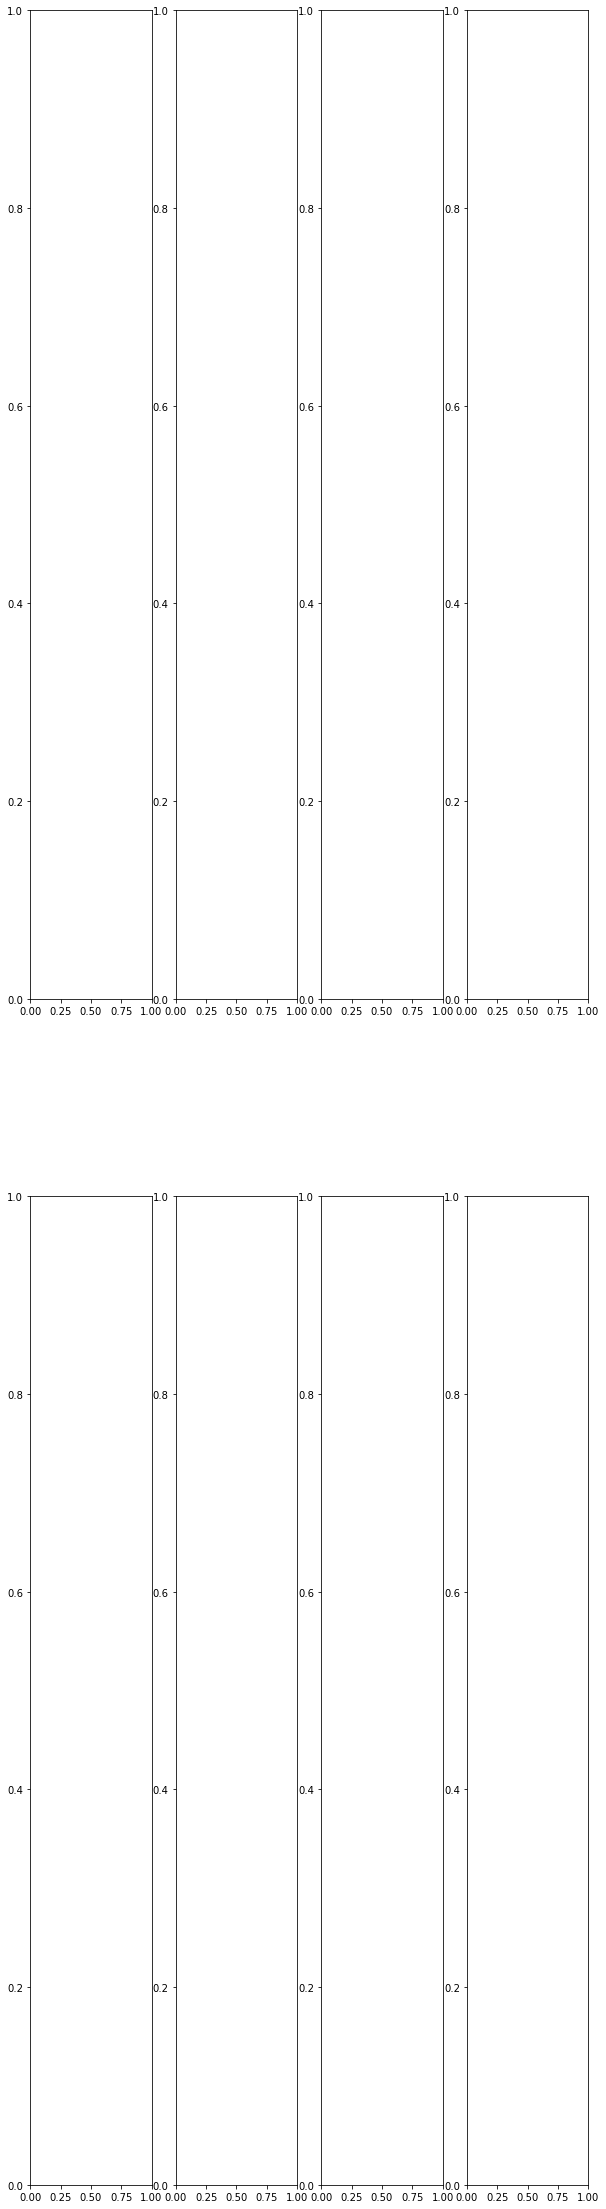

In [16]:
r = inData.results.rides
_, config, _ = nw.load("netwulf_config.json") # load config
_, config_schedule, _ = nw.load("netwulf_config_schedule.json") # load config
fig, axes = plt.subplots(2,4, figsize = (10,40))
i=0
for ALGO, algorithm in ALGOS.items():  # perform assignment for single prunings
    print(ALGO)
    if "pruned_{}".format(ALGO) in r.columns:
        this_rides = r[r["pruned_{}".format(ALGO)]==True]
    else:
        this_rides = r
    G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, this_rides)
    f, _ = nw.visualize(G, config = config_schedule,  plot_in_cell_below=False)
    _, _ = nw.draw_netwulf(f, fig = fig, ax = axes[0][i])
    this_schedule = r[r["UNIFORM-['total_group_cost']-['{}']-total_group_cost-min".format(ALGO)]==True]
    G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, this_schedule)
    f, _ = nw.visualize(G, config = config_schedule,  plot_in_cell_below=False)
    _, _ = nw.draw_netwulf(f, fig = fig, ax = axes[1][i])
    i+=1
    

### ExMAS 


two graphs for each algorithm: 
* first shareability potential groups
* then assignment, ILP solution for BPoA

nodes are travellers, links if they form a group, size is the degree (number of rides in which you may participate)

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,5)
_, _ = nw.visualize(G, config = config_schedule)
_, _ = nw.draw_netwulf(network_1, fig = fig, ax = axes[1][0])
_, _ = nw.draw_netwulf(network_windows, fig = fig, ax = axes[0])


In [42]:
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.schedule)
stylized_network, config_schedule = nw.visualize(G, config = config_schedule)  # create config
#nw.save("netwulf_config_schedule.json", stylized_network, config_schedule) # save config
#_, _ = nw.visualize(G, config = config_schedule)

### TNE 


In [ ]:
params.multi_platform_matching = True
params.assign_ride_platforms = False
inData = prunings.algo_TNE(inData, price_column='UNIFORM')  # apply pruning strategies for a given pricing strategy
inData = pipeline.single_eval(inData, params,
                     MATCHING_OBJS = ['UNIFORM'],  # this can be more
                     PRUNINGS = ['TNE'],  # and this can be more
                     PRICING = 'UNIFORM',  # this is taken from first level loop
                     minmax = ['min'], store_res = False)  # direction BPoA, WPoA
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.rides[inData.sblts.rides.pruned])
_, _ = nw.visualize(G, config = config)

In [ ]:
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.schedule)
_, _ = nw.visualize(G, config = config_schedule)

In [ ]:
params.multi_platform_matching = True
params.assign_ride_platforms = False
inData = prunings.algo_HERMETIC(inData, price_column='UNIFORM')  # apply pruning strategies for a given pricing strategy
inData = pipeline.single_eval(inData, params,
                     MATCHING_OBJS = ['UNIFORM'],  # this can be more
                     PRUNINGS = ['HERMETIC'],  # and this can be more
                     PRICING = 'UNIFORM',  # this is taken from first level loop
                     minmax = ['min'], store_res = False)  # direction BPoA, WPoA
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.rides[inData.sblts.rides.pruned])
_, _ = nw.visualize(G, config = config)

In [ ]:
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests, inData.sblts.schedule)
_, _ = nw.visualize(G, config = config_schedule)

---
(c) Rafał Kucharski, Delft, 2020